In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.colors as mcolors


def simulation(url):
    max_goals = 5
    simulations = 100000

    # Obtener el match_id del URL
    match_id = str(url.split('#')[1])

    # Buscar el archivo CSV de equipos
    current_directory = os.getcwd()
    teams_file = [filename for filename in os.listdir(current_directory) if match_id in filename and '(teams)' in filename]

    if not teams_file:
        print(f'No se encontraron archivos CSV (teams) para el match_id {match_id} en {current_directory}.')
        return None

    # Leer el archivo CSV de equipos
    csv_teams = teams_file[0]
    df_teams = pd.read_csv(os.path.join(current_directory, csv_teams))

    # Extraer datos del DataFrame de equipos
    home = df_teams['team'].iloc[0]
    away = df_teams['team'].iloc[1]
    home_xg = df_teams['xG'].iloc[0]
    away_xg = df_teams['xG'].iloc[1]
    home_color = df_teams['color'].iloc[0]
    away_color = df_teams['color'].iloc[1]

    # Simulación de los resultados del partido
    results = []
    for _ in range(simulations):
        home_goals = np.random.poisson(home_xg)
        away_goals = np.random.poisson(away_xg)
        home_goals = min(home_goals, max_goals)
        away_goals = min(away_goals, max_goals)
        results.append((home_goals, away_goals))

    # Crear DataFrame de resultados
    results_df = pd.DataFrame(results, columns=['home_goals', 'away_goals'])

    # Crear matriz de probabilidades
    matrix = np.zeros((max_goals + 1, max_goals + 1))
    for _, row in results_df.iterrows():
        matrix[row['home_goals'], row['away_goals']] += 1
    matrix /= simulations


    # Calcular el valor máximo de probabilidad en toda la matriz
    max_prob = np.max(matrix)
    # Encontrar la posición de la celda con el valor máximo
    max_prob_index = np.unravel_index(np.argmax(matrix), matrix.shape)

    # Calcular las coordenadas del rectángulo para resaltar la celda de mayor probabilidad
    rect_x = max_prob_index[1] + 0.05  # Ajustar la posición x
    rect_y = max_prob_index[0] + 0.05  # Ajustar la posición y
    rect_width = 0.9  # Ancho del rectángulo
    rect_height = 0.9  # Alto del rectángulo

    # Agregar un rectángulo al gráfico para resaltar la celda de mayor probabilidad
    rect = plt.Rectangle((rect_x, rect_y), rect_width, rect_height, fill=False, edgecolor='Black', lw=6)

    # Definir colormaps para i > j, i < j, i = j con el mismo rango
    cmap_i_greater_j = mcolors.LinearSegmentedColormap.from_list('custom_i_greater_j', [(1, 1, 1), mcolors.to_rgb(home_color)], N=256)
    cmap_i_less_j = mcolors.LinearSegmentedColormap.from_list('custom_i_less_j', [(1, 1, 1), mcolors.to_rgb(away_color)], N=256)
    cmap_i_equal_j = mcolors.LinearSegmentedColormap.from_list('custom_i_equal_j', [(1, 1, 1), (0, 0, 0)], N=256)


    fig, ax = plt.subplots(figsize=(8, 8))

    sns.heatmap(matrix, annot=True, fmt=".1%", cmap=cmap_i_equal_j, vmin=0, vmax=max_prob, cbar=False, ax=ax)
    sns.heatmap(matrix, annot=False, fmt=".1%", cmap=cmap_i_greater_j, mask=np.triu(matrix), vmin=0, vmax=max_prob, cbar=False, ax=ax)
    sns.heatmap(matrix, annot=False, fmt=".1%", cmap=cmap_i_less_j, mask=np.tril(matrix), vmin=0, vmax=max_prob, cbar=False, ax=ax)
    ax.add_patch(rect) #Grafica el rectánguo
    

    for text, (i, j) in zip(ax.texts, np.ndindex(matrix.shape)):
        text.set_rotation(45)
        text.set_fontsize(10)
        prob = matrix[i, j]  # Obtener la probabilidad correspondiente
        text.set_text(f'{i} - {j}\n{prob:.1%}')  # Mostrar i - j y la probabilidad en porcentaje

        # Centrar el texto horizontal y verticalmente en la celda
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
            
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    for tick in ax.get_yticklabels():
        tick.set_rotation(45)

    # Ocultar título del heatmap
    ax.set_title('')
    
    # Invertir el eje x (eje inferior) para colocarlo arriba
    ax.invert_yaxis()

    # Mostrar las marcas en los ejes
    #plt.xticks(np.arange(7))  # Mostrar marcas en el eje x
    #plt.yticks(np.arange(7))  # Mostrar marcas en el eje y

    # Calcular probabilidades y resultados
    home_win = np.sum(np.tril(matrix, -1))
    away_win = np.sum(np.triu(matrix, 1))
    draw = np.sum(np.diag(matrix))
    home_xPts = home_win * 3.0 + draw * 1.0
    away_xPts = away_win * 3.0 + draw * 1.0

    # Imprimir resultados
    print(f'{home} tuvo {round(home_win * 100, 2)}% probabilidades de ganar.')
    print(f'{away} tuvo {round(away_win * 100, 2)}% probabilidades de ganar.')
    print(f'Hubo {round(draw * 100, 2)}% de probabilidades de empate.')

    # Guardar imagen
    plt.savefig('rotate_temp.png', dpi=300)  # Guardar el gráfico con una resolución de 300 DPI
    # Cargar la imagen original desde el archivo PNG
    rotate_temp = Image.open('rotate_temp.png')

    # Especificar los límites de la región a recortar de (x1,y1) a (x2,y2)
    x1, y1, x2, y2 = 200.5, 187, 2260.5, 2247

    # Obtener la región de interés (ROI) utilizando los límites especificados
    rotate_temp = rotate_temp.crop((x1, y1, x2, y2))

    rotated_image = rotate_temp.rotate(-45, expand=True)

    # Guardar la imagen rotada como un archivo PNG
    print(teams_file[0])
    png_file = teams_file[0].replace('teams','matrix').replace('.csv','')
    rotated_image.save(f'{png_file}.png')

    return home_win, draw, away_win, home_xPts, away_xPts

In [8]:
def import_img_beta(url):

    # Obtener el match_id del URL
    match_id = str(url.split('#')[1])

    # Buscar el archivo CSV de equipos
    current_directory = os.getcwd()
    teams_file = [filename for filename in os.listdir(current_directory) if match_id in filename and '(teams)' in filename]

    if not teams_file:
        print(f'No se encontraron archivos CSV (teams) para el match_id {match_id} en {current_directory}.')
        return None
    
    # Cargar la imagen guardada y mostrarla en una nueva figura
    png_file = teams_file[0].replace('teams','matrix').replace('.csv','')

    image = Image.open(f'{png_file}.png')

    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    #plt.show()

    return

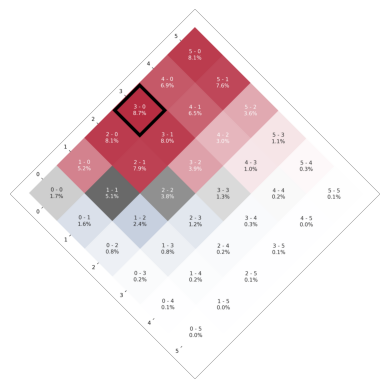

In [10]:
def import_img(url, ax=None):
    # Obtener el match_id del URL
    match_id = str(url.split('#')[1])

    # Buscar el archivo CSV de equipos
    current_directory = os.getcwd()
    teams_file = [filename for filename in os.listdir(current_directory) if match_id in filename and '(teams)' in filename]

    if not teams_file:
        print(f'No se encontraron archivos CSV (teams) para el match_id {match_id} en {current_directory}.')
        return None
    
    # Cargar la imagen guardada
    png_file = teams_file[0].replace('teams','matrix').replace('.csv','')
    image = Image.open(f'{png_file}.png')

    if ax is None:
        # Mostrar la imagen en una nueva figura
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        # Mostrar la imagen en el eje (ax) especificado
        ax.imshow(image)
        ax.axis('off')

# Ejemplo de uso:
url = 'https://www.fotmob.com/es/matches/rosario-central-vs-argentinos-juniors/3d4b5p#4393640'
fig, ax = plt.subplots()
import_img(url, ax)
plt.show()


Argentinos Juniors tuvo 79.9% probabilidades de ganar.
Rosario Central tuvo 7.98% probabilidades de ganar.
Hubo 12.11% de probabilidades de empate.
Copa de la Liga Profesional 2024 Round 11 4393640 - Argentinos Juniors 3 v 0 Rosario Central (teams).csv


(0.79902,
 0.12113000000000002,
 0.07984999999999999,
 2.5181899999999997,
 0.36068)

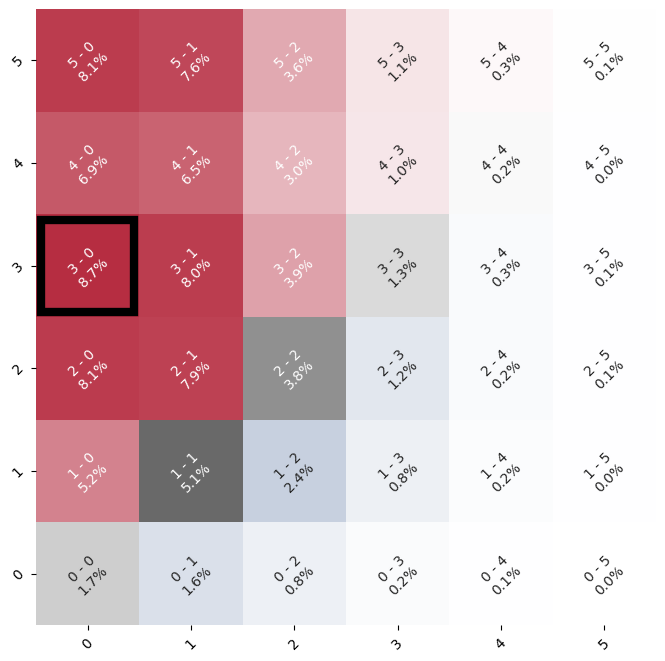

In [6]:
# Ejemplo de uso:
url = 'https://www.fotmob.com/es/matches/rosario-central-vs-argentinos-juniors/3d4b5p#4393640'
#fig, ax = plt.subplots(figsize=(8, 8))
simulation(url)

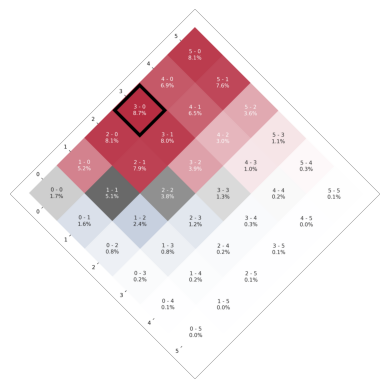

In [9]:
import_img(url)